In [12]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tqdm import tqdm
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import cv2
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Model
from tensorflow.keras import callbacks
from sklearn.utils import shuffle

%matplotlib inline

In [ ]:
!pip install tensorflow==2.4.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
classes = {'Normal':0,'Pneumonia':1,'Covid':2}
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=[IMAGE_WIDTH, IMAGE_HEIGHT]
BATCH_SIZE=32
N_CLASSES = 3
EPOCHS = 20

In [4]:
# Normal_DIR='/content/drive/MyDrive/COVID-ChestXray-15k-dataset/train/NORMAL'
# Covid_DIR='/content/drive/MyDrive/COVID-ChestXray-15k-dataset/train/COVID'
# Pheumonia_DIR='/content/drive/MyDrive/COVID-ChestXray-15k-dataset/train/PNEUMONIA'
# Normal_DIR='/content/drive/MyDrive/COVID-ChestXray-15k-dataset/test/NORMAL'
# Covid_DIR='/content/drive/MyDrive/COVID-ChestXray-15k-dataset/test/COVID'
# Pheumonia_DIR='/content/drive/MyDrive/COVID-ChestXray-15k-dataset/test/PNEUMONIA'
Normal_DIR='train/NORMAL'
Covid_DIR='train/COVID'
Pheumonia_DIR='train/PNEUMONIA'
Normal_DIR_TEST='test/NORMAL'
Covid_DIR_TEST='test/COVID'
Pheumonia_DIR_TEST='test/PNEUMONIA'

In [5]:
def assign_label(img,image_type):
    return image_type

X_train = []
y_train = []
X_test = []
y_test = []

def make_train_data(image_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            label=assign_label(img,image_type)
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
            X_train.append(np.array(img))
            y_train.append(str(label))
        except:
            print('Error here')
def make_test_data(image_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            label=assign_label(img,image_type)
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
            X_test.append(np.array(img))
            y_test.append(str(label))
        except:
            print('Error here')

In [9]:
make_train_data(classes.get('Normal'), Normal_DIR)

100%|██████████████████████████████████████████████████████████████████████████████| 4449/4449 [01:10<00:00, 63.29it/s]


In [10]:
make_train_data(classes.get('Pneumonia'), Pheumonia_DIR)

100%|██████████████████████████████████████████████████████████████████████████████| 4680/4680 [00:58<00:00, 79.82it/s]


In [11]:
make_train_data(classes.get('Covid'), Covid_DIR)

100%|██████████████████████████████████████████████████████████████████████████████| 4089/4089 [01:55<00:00, 35.28it/s]

Error here


In [6]:
make_test_data(classes.get('Normal'), Normal_DIR_TEST)

100%|████████████████████████████████████████████████████████████████████████████████| 551/551 [00:15<00:00, 36.71it/s]


In [7]:
make_test_data(classes.get('Pneumonia'), Pheumonia_DIR_TEST)

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:03<00:00, 86.62it/s]


In [8]:
make_test_data(classes.get('Covid'), Covid_DIR_TEST)

100%|████████████████████████████████████████████████████████████████████████████████| 331/331 [00:03<00:00, 90.11it/s]


In [16]:
print(len(X_train))
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
X_train = np.array(X_train)
X_train = X_train / 255
X_test = np.array(X_test)
X_test = X_test / 255
X_train.shape, X_test.shape

((13217, 150, 150, 3), (1202, 150, 150, 3))

In [20]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((13217, 150, 150, 3), (13217,), (1202, 150, 150, 3), (1202,))

In [21]:
k = len(set(y_train))
print("Number of classes ", k)

Number of classes  3


In [22]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [23]:
y_train.dtype, y_test.dtype

(dtype('float32'), dtype('float32'))

In [24]:
X_train,y_train = shuffle(X_train,y_train)
X_test,y_test = shuffle(X_test,y_test)

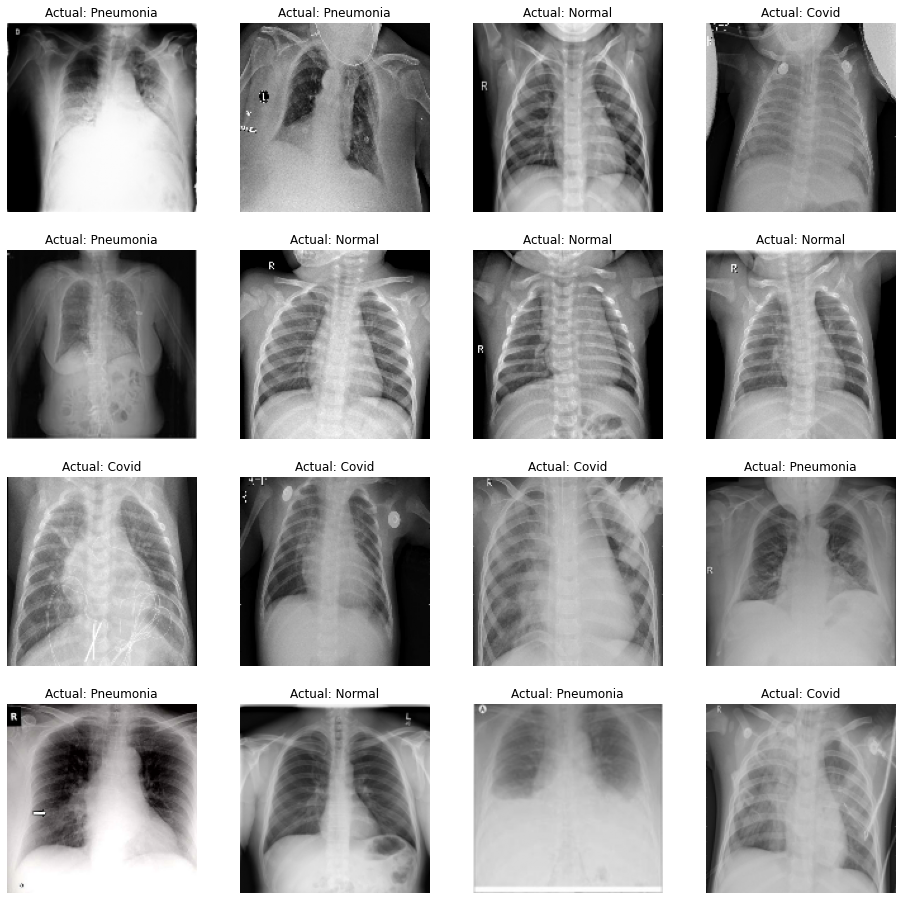

In [25]:
labels = '''Normal
Covid
Pneumonia'''.split("\n")

plt.figure(figsize=(16,16))
j = 1
for i in np.random.randint(0,1000,16):
    plt.subplot(4,4,j); j+=1
    plt.imshow(X_train[i],cmap = 'Greys')
    plt.axis('off')
    plt.title("Actual: {}".format(labels[np.argmax(y_train[i])]))
    #plt.title('{} / {}'.format(labels[y_train[i]],y_train[i]))

In [26]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

ptm.trainable = False

In [27]:
i = ptm.output
x = layers.Flatten()(i)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
model_output = layers.Dense(k, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=model_output)
ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [29]:
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [32]:
batch_size = 128

# train_path = '/content/drive/MyDrive/COVID-ChestXray-15k-dataset/train'
# valid_path = '/content/drive/MyDrive/COVID-ChestXray-15k-dataset/valid'
train_path = 'train'
valid_path = 'valid'

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
    shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 13797 images belonging to 3 classes.
Found 4556 images belonging to 3 classes.


In [33]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [34]:
from glob import glob

image_files = glob(train_path + '/*/*.*')
valid_image_files = glob(valid_path + '/*/*.*')

In [35]:
len(valid_image_files)

4556

In [ ]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

In [ ]:
train_generator2 = gen_test.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
model.evaluate_generator(
    train_generator2,
    steps=int(np.ceil(len(image_files) / batch_size)))

Found 14999 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.12875796854496002, 0.9491150379180908]

The class of this is: 0


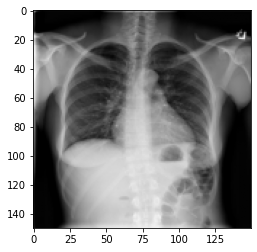

In [ ]:
print("The class of this is: {}".format(np.argmax(y_train[10])))
plt.imshow(X_train[10], cmap='gray')
plt.show()

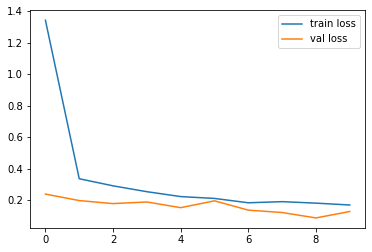

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

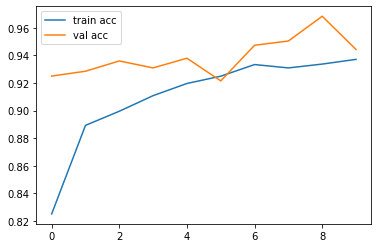

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


p_test = model.predict(X_train).argmax(axis=1)
cm = confusion_matrix(np.argmax(y_train, axis= 1), p_test)
plot_confusion_matrix(cm, list(range(5)))

In [ ]:
misclassified_idx = np.where(p_test != np.argmax(y_test, axis= 1))[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[np.argmax(y_test[i])], labels[p_test[i]]));